In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [2]:
# Seting random seed for reproducibility
torch.manual_seed(42)

In [3]:
# Checking if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Available device: ', device)

Available device:  cuda


# 1) Loading Fashion MNIST dataset

#### ABOUT THE FASHION_MNIST DATASET:

The Fashion-MNIST is a dataset of Zalando's article images. The Fashion-MNIST dataset is a popular dataset used for benchmarking machine learning models, particularly in computer vision. It is designed as a drop-in replacement for the original MNIST dataset but contains images of clothing items instead of handwritten digits.

#### **Overview of the Fashion-MNIST Dataset:**
- **Size:** 70,000 grayscale images  
- **Training set:** 60,000 images  
- **Test set:** 10,000 images  
- **Image dimensions:** 28x28 pixels  
- **Number of classes:** 10 (each representing a type of clothing)  

#### **Classes (Labels) in Fashion-MNIST**
Each image belongs to one of the following 10 classes:

| Label | Class Name     |
|-------|--------------|
| 0     | T-shirt/top  |
| 1     | Trouser      |
| 2     | Pullover     |
| 3     | Dress        |
| 4     | Coat         |
| 5     | Sandal       |
| 6     | Shirt        |
| 7     | Sneaker      |
| 8     | Bag          |
| 9     | Ankle boot   |

#### **Key Features:**
- The dataset is more challenging than MNIST because the images have more complex patterns.  
- It is intended to be used as a benchmark for machine learning and deep learning models.  
- Each pixel in the images has values ranging from **0 to 255** (grayscale intensity).  
- Unlike color images (RGB), these images have only **one channel**.  
- The images are already preprocessed, so they are in **NumPy array format**.  


In [4]:
from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


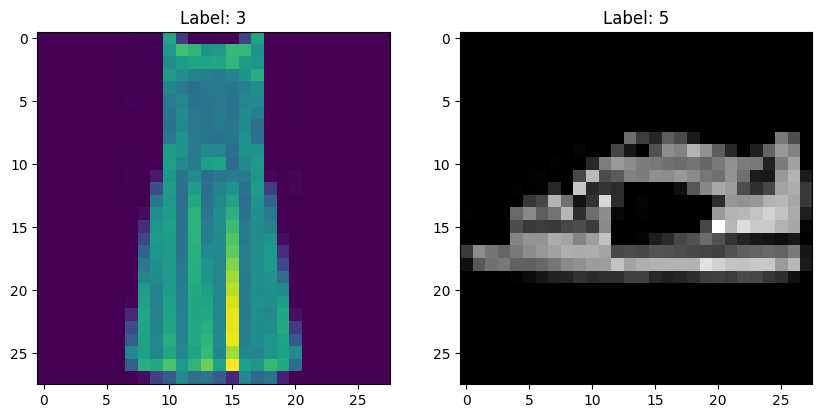

In [6]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))

# 1st image
axes[0].imshow(x_train[31])
axes[0].set_title('Label: '+ str(y_train[31]))

# 2nd image in grayscale
axes[1].imshow(x_train[13], cmap = 'gray')
axes[1].set_title('Label: '+ str(y_train[13]))

plt.show()

# 2) Creating Dataset class

In [7]:
class MyDataset(Dataset):

  def __init__(self, features, label, transform = None):

    # Loading features and label from the dataset
    self.features = features
    self.label = label

    self.transform = transform      # Defining transformation, if a transformation function is passed by user while making the object of this class

  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx):

    # Getting features and label of a particular row
    x = self.features[idx]
    y = self.label[idx]

    if self.transform:
      x = self.transform(x)                               # We get x as tensor after applying the transformation

    x = x.reshape(1, 28, 28).float()                      # Reshape to (channels, height, width) and convert to float

    y = torch.tensor(y, dtype = torch.long)               # Converting y to tensor too and setting dtype to long for CrossEntropyLoss

    return x, y

# 3) Creating transformation function

In [8]:
def transformation(features):

  features = features/255.0                   # Scaling the data
  features = torch.tensor(features)           # Converting to tensor
  return features

# 4) Creating Dataset & DataLoader object

In [9]:
train_dataset = MyDataset(x_train, y_train, transform = transformation)
test_dataset = MyDataset(x_test, y_test, transform = transformation)

In [10]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False, pin_memory = True)

# 5) Building CNN Architecture

In [11]:
class CNNmodel(nn.Module):

  def __init__(self, num_in_channels):
    super(CNNmodel, self).__init__()

    # Creating convolution layers
    self.convlayers = nn.Sequential(

        nn.Conv2d(in_channels = num_in_channels, out_channels = 32, kernel_size = 3, padding = 'same'),    # in_channels: Number of channels in input (i.e grayscale=1, RGB=3),
                                                                                             # out_channels: number of filters/kernels to be applied in the convolutional layer.
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size = 2, stride = 2),

        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 'same'),    # Here the in_channels is 32, cause the input is a feature map (28,28,32)
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )


    # Creating FC layers
    self.FClayers = nn.Sequential(
        nn.Flatten(),

        nn.Linear(in_features = 64*7*7, out_features = 128),      # 'in_features' is number of inputs comming to the layer
        nn.ReLU(),
        nn.Dropout(p = 0.3),

        nn.Linear(in_features = 128, out_features = 64),          # 'out_features' is number of neurons in this layer
        nn.ReLU(),
        nn.Dropout(p = 0.3),

        nn.Linear(in_features = 64, out_features = 10)
    )


  def forward(self, x):

    y_pred = self.convlayers(x)
    y_pred = self.FClayers(y_pred)
    return y_pred

  def loss_function(self, y_pred, y):

    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(y_pred, y)
    return loss

# 6) Training the model

In [12]:
# Making object of the model
model = CNNmodel(num_in_channels = 1)                 # All images are grayscale in dataset, so channels = 1
print(model)

# Creating optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

CNNmodel(
  (convlayers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (FClayers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.3, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [13]:
# Moving the model to GPU
model = model.to(device)

In [14]:
# Training the model

for epoch in range(25):

  total_epoch_loss = 0.0                                                    # Initialize total_epoch_loss for each epoch

  for batch_features, batch_label in train_loader:

    # move data to gpu
    batch_features, batch_label = batch_features.to(device), batch_label.to(device)

    # Forward pass
    y_pred = model.forward(batch_features)

    # loss calculation
    loss = model.loss_function(y_pred, batch_label)

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()

    # Reset the gradients
    optimizer.zero_grad()

    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')

Epoch: 1 , Loss: 0.4230326317369938
Epoch: 2 , Loss: 0.2894171301474174
Epoch: 3 , Loss: 0.2484630409821868
Epoch: 4 , Loss: 0.22439276268184186
Epoch: 5 , Loss: 0.2064360776702563
Epoch: 6 , Loss: 0.18917190721084673
Epoch: 7 , Loss: 0.1751848121235768
Epoch: 8 , Loss: 0.16188538354256501
Epoch: 9 , Loss: 0.15410368787224094
Epoch: 10 , Loss: 0.1413416060609122
Epoch: 11 , Loss: 0.1317558969175443
Epoch: 12 , Loss: 0.12381397704531749
Epoch: 13 , Loss: 0.11550566770940399
Epoch: 14 , Loss: 0.109162228036051
Epoch: 15 , Loss: 0.11089382017736013
Epoch: 16 , Loss: 0.10231695378395574
Epoch: 17 , Loss: 0.09472894479517514
Epoch: 18 , Loss: 0.0944117819094332
Epoch: 19 , Loss: 0.08832814564182967
Epoch: 20 , Loss: 0.08284111544643528
Epoch: 21 , Loss: 0.07818995015406788
Epoch: 22 , Loss: 0.08167998822850447
Epoch: 23 , Loss: 0.07586038278145134
Epoch: 24 , Loss: 0.07245505283665843
Epoch: 25 , Loss: 0.06966361249735734


# 7) Model Evaluation

In [15]:
# Setting model to evaluation mode
model.eval()

CNNmodel(
  (convlayers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (FClayers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.3, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [16]:
# Evaluation of model on test data

correct_pred = 0
total_samples = 0

with torch.no_grad():

  for batch_features, batch_label in test_loader:

    # Move data on GPU
    batch_features, batch_label = batch_features.to(device), batch_label.to(device)

    # Forward pass
    y_test_pred = model.forward(batch_features)

    # Get predicted class index
    _, predicted = torch.max(y_test_pred, 1)

    # Check if correctly predicted
    correct_pred += (predicted == batch_label).sum().item()

    # Total samples
    total_samples += batch_label.shape[0]


# Calculating Accuracy
acc = correct_pred/total_samples
print(f'Accuracy on test data: {acc*100}')

Accuracy on test data: 91.17
